## *Music Genre Classification*

### Task 1 (Feed Forward Neural Network)

#### Step 1 (Dataloading of MFCCs)

We first begin by preparing the dataloading part for the MFCCs. For this purpose we create a utility `load_mfccs` function located in `utils.py`. The function takes as argument the type of the dataset to load which is either train, test or val. It returns the features of the corresponding dataset as well as the labels for the given dataset. Each one of the labels "classical", "pop", "rock", and "blues" are mapped to the integers 0, 1, 2, and 3, respectively. Furthermore, we create a Pytorch dataset object that inherits from `torch.utils.data.Dataset` in order to feed the data to our Neural Network. The class is defined in `utils.py` under the name `VectorDataset`.

In [1]:
import numpy as np
import torch

from utils import load_mfccs, VectorDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay
from torch.optim import SGD

Using the function `load_mfccs` we load the dataset of the mfccs corresponding for the training set.

In [2]:
X, y = load_mfccs('train')

In [3]:
print(X.shape, y.shape)
print(X.dtype)

(3200, 26) (3200,)
float32


We check the distribution of the classes for the training set.

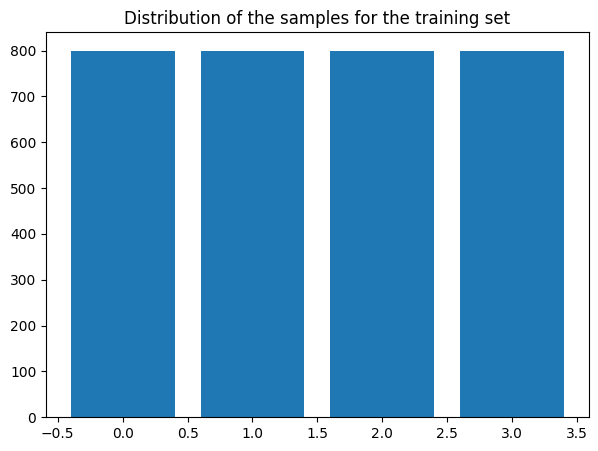

In [4]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(range(4), np.bincount(y))
ax.set_title('Distribution of the samples for the training set')
plt.show()

As we can see the dataset is balanced since each class on the training set contains exactly 800 samples. Below we define the three dataloaders that will be used for training, one for the training set, one for the validation and one for the test set.

In [5]:
X_train, y_train = load_mfccs(mode='train')
X_val, y_val = load_mfccs(mode='val')
X_test, y_test = load_mfccs(mode='test')

train_dloader = DataLoader(VectorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_dloader = DataLoader(VectorDataset(X_val, y_val), batch_size=16, shuffle=True)
test_dloader = DataLoader(VectorDataset(X_test, y_test), batch_size=16, shuffle=False)

#### Step 2 (Defining a Fully connected Neural Network)

In the second step we define the first type of Neural Network that we will use to train and classify the samples using the features with the MFCCs. The first architecture is a Fully Connected Neural Network with 4 layers each one of them consisting of 26, 128, 32 and 4 neurons, respectively. The number 26 corresponds to the number of input features and the 4 is the number of classes (classical, hiphop, blues, rock_metal_hardrock). The architecture is located in `models.py` under the name `MLP`. Below you can see the architecture of this Neural Network.

In [6]:
from models import MLP

In [7]:
model = MLP()
model

MLP(
  (body): ModuleList(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

#### Step 3 & 4 (Training loop & Validation loop)

In this step we create a custom function, named `training_loop` to handle the training of the Neural Network. The arguments of the function are the number of epochs, the optimizer to be used for training, the two dataloaders corresponding to the training/val sets, and the loss function to be used. The function is in `utils.py`.

Furthermore, we design a validation loop through the function `validation_loop` located in `utils.py`. The arguments of the function is the trained model, the test_dloader, and the loss function corresponding to the test samples. The function returns 

- (i) The average loss across all samples
- (ii) The average f1 macro
- (iii) The accuracy, and
- (iv) The confusion matrix corresponding to the classification.

#### Step 5 (Training the Feed Forward Neural Network)

In this step we train the Feed Forward Neural Network defined in Step 2. We use the utility function `training_loop` and we measure the training time on the CPU. Below we also define the number of epochs, the optimizer, the loss function and the learning rate to be used for training. Furthermore, we use the `validation_loop` to test the model's performance on the test set.

In [8]:
EPOCHS = 30
learning_rate = 2e-3
loss_fn = nn.CrossEntropyLoss()
optim = SGD(model.parameters(), lr=learning_rate)

In [9]:
from utils import training_loop, validation_loop

Epoch 1 /30. Train Loss: 1.400. Val Loss: 1.379


Epoch 2 /30. Train Loss: 1.374. Val Loss: 1.355


Epoch 3 /30. Train Loss: 1.352. Val Loss: 1.334


Epoch 4 /30. Train Loss: 1.330. Val Loss: 1.307


Epoch 5 /30. Train Loss: 1.308. Val Loss: 1.293


Epoch 6 /30. Train Loss: 1.282. Val Loss: 1.260


Epoch 7 /30. Train Loss: 1.257. Val Loss: 1.239


Epoch 8 /30. Train Loss: 1.231. Val Loss: 1.200


Epoch 9 /30. Train Loss: 1.200. Val Loss: 1.183


Epoch 10/30. Train Loss: 1.171. Val Loss: 1.139


Epoch 11/30. Train Loss: 1.146. Val Loss: 1.133


Epoch 12/30. Train Loss: 1.119. Val Loss: 1.132


Epoch 13/30. Train Loss: 1.095. Val Loss: 1.082


Epoch 14/30. Train Loss: 1.078. Val Loss: 1.037


Epoch 15/30. Train Loss: 1.052. Val Loss: 1.041


Epoch 16/30. Train Loss: 1.036. Val Loss: 1.010


Epoch 17/30. Train Loss: 1.026. Val Loss: 0.997


Epoch 18/30. Train Loss: 1.015. Val Loss: 1.038


Epoch 19/30. Train Loss: 1.000. Val Loss: 0.985


Epoch 20/30. Train Loss: 0.985. Val Loss: 0.939


Epoch 21/30. Train Loss: 0.975. Val Loss: 0.930


Epoch 22/30. Train Loss: 0.962. Val Loss: 0.922


Epoch 23/30. Train Loss: 0.959. Val Loss: 0.919


Epoch 24/30. Train Loss: 0.957. Val Loss: 0.889


Epoch 25/30. Train Loss: 0.958. Val Loss: 0.910


Epoch 26/30. Train Loss: 0.947. Val Loss: 0.879


Epoch 27/30. Train Loss: 0.944. Val Loss: 0.940


Epoch 28/30. Train Loss: 0.944. Val Loss: 0.861


Epoch 29/30. Train Loss: 0.935. Val Loss: 0.876


Epoch 30/30. Train Loss: 0.928. Val Loss: 0.941

- Total training time: 5.80 (secs)


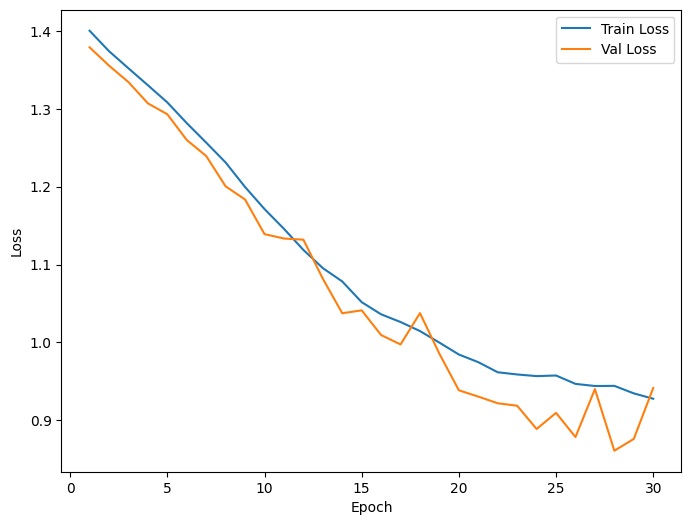

In [10]:
training_loop(EPOCHS, model, train_dloader, val_dloader, optim, loss_fn)

In [11]:
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn)

100%|██████████| 86/86 [00:00<00:00, 2773.24it/s]


In [12]:
print(f'Total loss: {loss:.3f}\nF1 score: {f1:.3f}\nAccuracy: {acc:.3f}')

Total loss: 1.037
F1 score: 0.568
Accuracy: 0.576


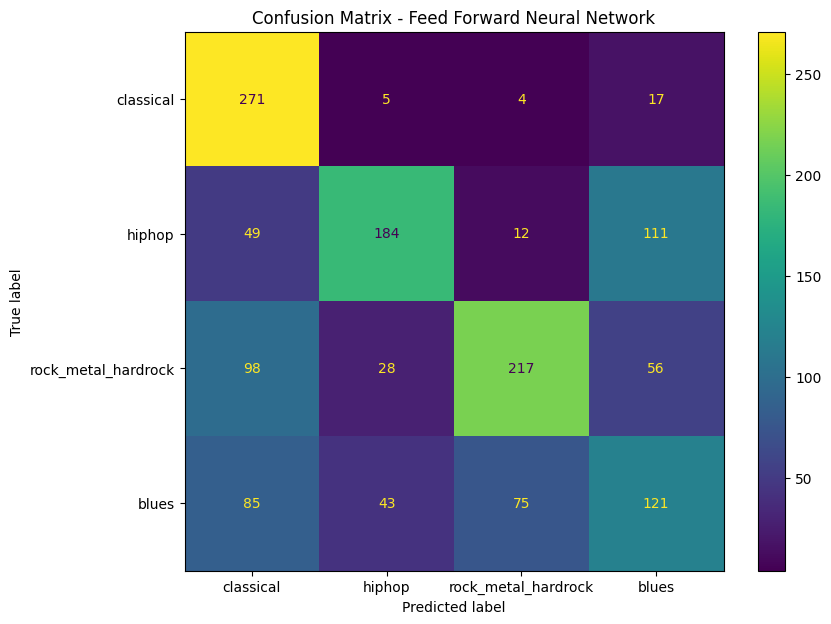

In [13]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - Feed Forward Neural Network')
plt.show()

#### Step 6 (Training on GPU)

Now, we move the model on the GPU and we perform the same training as before and measure the time difference.

In [14]:
# Check if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce GTX 1050


In [15]:
model = MLP()
model = model.to(device)
loss_fn = loss_fn.to(device)
optim = SGD(model.parameters(), lr=learning_rate)

Epoch 1 /30. Train Loss: 1.408. Val Loss: 1.385


Epoch 2 /30. Train Loss: 1.373. Val Loss: 1.360


Epoch 3 /30. Train Loss: 1.350. Val Loss: 1.342


Epoch 4 /30. Train Loss: 1.331. Val Loss: 1.325


Epoch 5 /30. Train Loss: 1.304. Val Loss: 1.296


Epoch 6 /30. Train Loss: 1.281. Val Loss: 1.263


Epoch 7 /30. Train Loss: 1.257. Val Loss: 1.237


Epoch 8 /30. Train Loss: 1.228. Val Loss: 1.218


Epoch 9 /30. Train Loss: 1.199. Val Loss: 1.182


Epoch 10/30. Train Loss: 1.175. Val Loss: 1.149


Epoch 11/30. Train Loss: 1.142. Val Loss: 1.136


Epoch 12/30. Train Loss: 1.117. Val Loss: 1.102


Epoch 13/30. Train Loss: 1.092. Val Loss: 1.082


Epoch 14/30. Train Loss: 1.067. Val Loss: 1.064


Epoch 15/30. Train Loss: 1.051. Val Loss: 1.032


Epoch 16/30. Train Loss: 1.029. Val Loss: 1.039


Epoch 17/30. Train Loss: 1.021. Val Loss: 0.981


Epoch 18/30. Train Loss: 1.006. Val Loss: 0.966


Epoch 19/30. Train Loss: 0.996. Val Loss: 0.952


Epoch 20/30. Train Loss: 0.984. Val Loss: 0.953


Epoch 21/30. Train Loss: 0.974. Val Loss: 1.034


Epoch 22/30. Train Loss: 0.963. Val Loss: 0.977


Epoch 23/30. Train Loss: 0.962. Val Loss: 0.922


Epoch 24/30. Train Loss: 0.955. Val Loss: 0.898


Epoch 25/30. Train Loss: 0.958. Val Loss: 0.891


Epoch 26/30. Train Loss: 0.947. Val Loss: 0.878


Epoch 27/30. Train Loss: 0.938. Val Loss: 0.930


Epoch 28/30. Train Loss: 0.937. Val Loss: 0.896


Epoch 29/30. Train Loss: 0.937. Val Loss: 0.907


Epoch 30/30. Train Loss: 0.926. Val Loss: 0.905

- Total training time: 10.80 (secs)


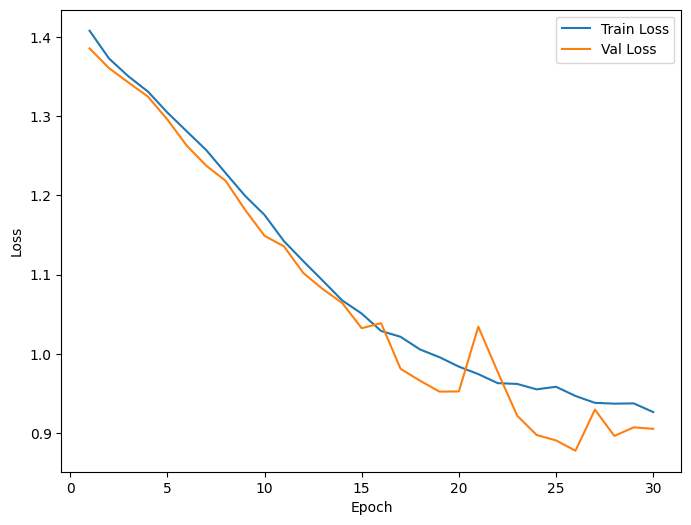

In [16]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device
)


#### Step 7 (Choosing the best model)

In this step we train again the Feed Forward Neural Network and keep the model with the highest f1 score on the validation set. To implement this on code we add a boolean flag `keep_best` on the `training_loop`. When this flag is set to True then the model with the lowest f1 score on the validation set is stored in a `.pt` file. Below we see the results of this model too.

In [17]:
model = MLP()
optim = SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

Epoch 1 /30. Train Loss: 1.392. Val Loss: 1.363


Epoch 2 /30. Train Loss: 1.361. Val Loss: 1.343


Epoch 3 /30. Train Loss: 1.344. Val Loss: 1.326


Epoch 4 /30. Train Loss: 1.323. Val Loss: 1.306


Epoch 5 /30. Train Loss: 1.298. Val Loss: 1.284


Epoch 6 /30. Train Loss: 1.278. Val Loss: 1.253


Epoch 7 /30. Train Loss: 1.247. Val Loss: 1.261


Epoch 8 /30. Train Loss: 1.221. Val Loss: 1.199


Epoch 9 /30. Train Loss: 1.197. Val Loss: 1.196


Epoch 10/30. Train Loss: 1.166. Val Loss: 1.145


Epoch 11/30. Train Loss: 1.145. Val Loss: 1.121


Epoch 12/30. Train Loss: 1.120. Val Loss: 1.098


Epoch 13/30. Train Loss: 1.098. Val Loss: 1.072


Epoch 14/30. Train Loss: 1.079. Val Loss: 1.044


Epoch 15/30. Train Loss: 1.058. Val Loss: 1.012


Epoch 16/30. Train Loss: 1.043. Val Loss: 1.010


Epoch 17/30. Train Loss: 1.028. Val Loss: 0.982


Epoch 18/30. Train Loss: 1.014. Val Loss: 0.960


Epoch 19/30. Train Loss: 0.997. Val Loss: 1.022


Epoch 20/30. Train Loss: 0.994. Val Loss: 0.959


Epoch 21/30. Train Loss: 0.987. Val Loss: 0.936


Epoch 22/30. Train Loss: 0.972. Val Loss: 0.946


Epoch 23/30. Train Loss: 0.971. Val Loss: 0.970


Epoch 24/30. Train Loss: 0.965. Val Loss: 0.924


Epoch 25/30. Train Loss: 0.960. Val Loss: 0.931


Epoch 26/30. Train Loss: 0.951. Val Loss: 0.923


Epoch 27/30. Train Loss: 0.950. Val Loss: 0.876


Epoch 28/30. Train Loss: 0.944. Val Loss: 0.913


Epoch 29/30. Train Loss: 0.948. Val Loss: 0.869


Epoch 30/30. Train Loss: 0.940. Val Loss: 0.872

- Total training time: 5.95 (secs)
- Best F1 score: 0.6825317552162561 on epoch 29


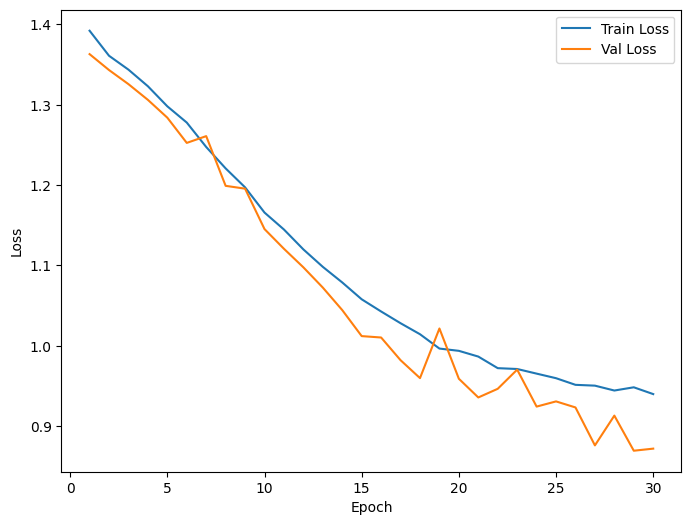

In [18]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device='cpu',
    keep_best=True
)


In [19]:
# Validating the best model
model = MLP()
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn)

100%|██████████| 86/86 [00:00<00:00, 2676.21it/s]


In [20]:
print(f'-Total Loss: {loss:3f}\n- F1 score: {f1:.3f}\n- Accuracy: {acc:.3f}')

-Total Loss: 0.968689
- F1 score: 0.610
- Accuracy: 0.600


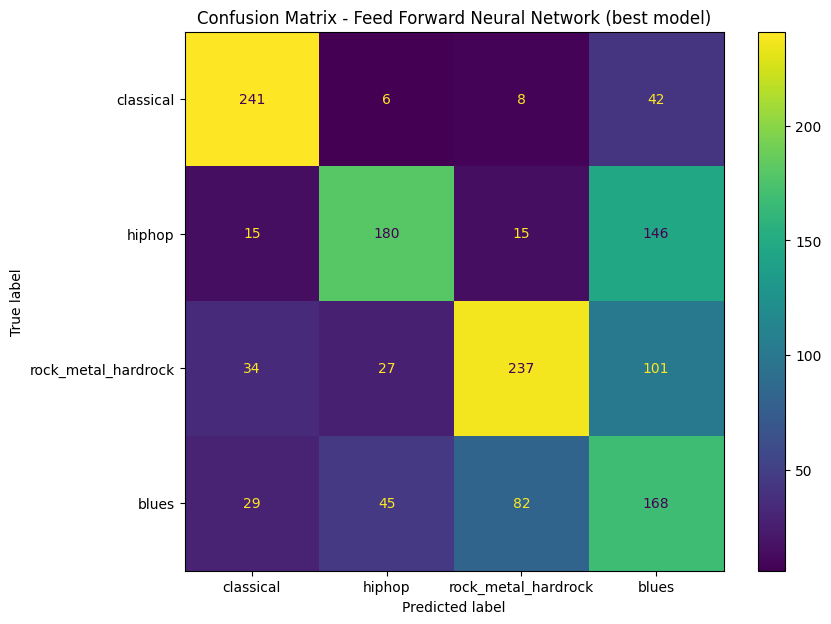

In [21]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - Feed Forward Neural Network (best model)')
plt.show()

### Task 2 (Convolutional Neural Network)

In the second part of this task we build a CNN and train it by using the melspectrogram representations of the audio segments. 

#### Step 1 (DataLoading and Visualizations)

As in the case of the Feed Forward Neural Network we define a utility function named `load_spectrograms` in order to parse the data corresponding to the mel-spectrogram representations. Below you can see the spectrograms for each genre from the training set.

In [22]:
from utils import load_spectrograms, INV_CLASS_MAPPING

In [23]:
X, y = load_spectrograms("train")

In [24]:
print(X.shape, y.shape)

(3200, 21, 128) (3200,)


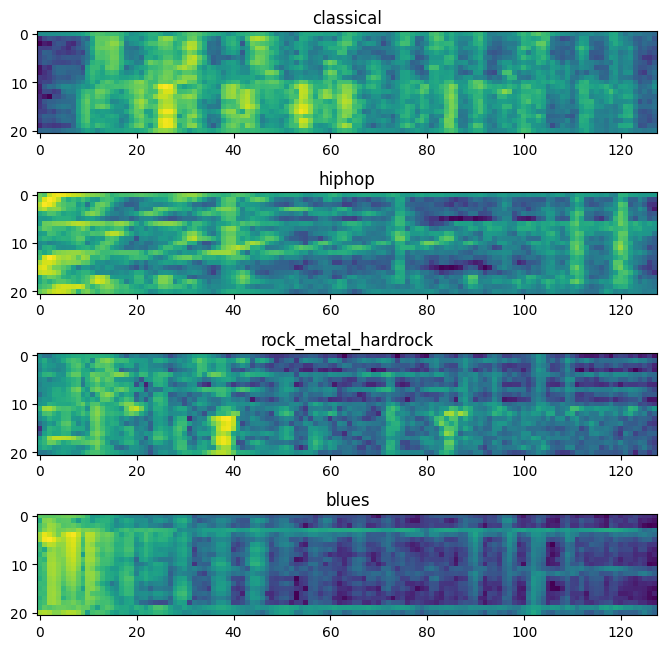

In [25]:
fig, ax = plt.subplots(figsize = (8, 8), nrows=4)

for i in range(4):
    idx = np.argwhere(y == i)[0].item()
    S = X[idx]
    ax[i].imshow(S)
    ax[i].set_title(INV_CLASS_MAPPING[i])

plt.show()

#### Step 2 (Defining the CNN architecture)

In this step we are asked to design a CNN consisting of:

1. Four convolutional layers with kernel size equal to 5 such that the sequence of channels is 1, 16, 32, 64, 128
2. The output of the last convolutional layer is the input to a fully connected neural network consisting of 5 layers with number of neurons: x (the dimension of the last convolutional layer), 1024, 256, 32, out_dim, where out_dim is the number of classes which is 4 in our case.

The architecture is defined in `models.py` under the class name `CNN`.

In [26]:
from models import CNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(H=21, W=128).to(device)

#### Step 3 (Training the CNN - 1st Attempt)

For the training of the CNN we use the same function (`training_loop`) as in the case of the Feed Forward Neural Network. Furthermore, we define a new dataset class to handle the preprocessing step of the spectrograms to serve as input to the CNN.

In [27]:
EPOCHS = 30
learning_rate = 2e-3
loss_fn = nn.CrossEntropyLoss().to(device)
optim = SGD(model.parameters(), lr=learning_rate)

In [28]:
from utils import SpectrogramDataset

In [29]:
train_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("train")), batch_size=16, shuffle=True)
val_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("val")), batch_size=16, shuffle=True)
test_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("test")), batch_size=16, shuffle=False)

Epoch 1 /30. Train Loss: nan. Val Loss: nan


Epoch 2 /30. Train Loss: nan. Val Loss: nan


Epoch 3 /30. Train Loss: nan. Val Loss: nan


Epoch 4 /30. Train Loss: nan. Val Loss: nan


Epoch 5 /30. Train Loss: nan. Val Loss: nan


Epoch 6 /30. Train Loss: nan. Val Loss: nan


Epoch 7 /30. Train Loss: nan. Val Loss: nan


Epoch 8 /30. Train Loss: nan. Val Loss: nan


Epoch 9 /30. Train Loss: nan. Val Loss: nan


Epoch 10/30. Train Loss: nan. Val Loss: nan


Epoch 11/30. Train Loss: nan. Val Loss: nan


Epoch 12/30. Train Loss: nan. Val Loss: nan


Epoch 13/30. Train Loss: nan. Val Loss: nan


Epoch 14/30. Train Loss: nan. Val Loss: nan


Epoch 15/30. Train Loss: nan. Val Loss: nan


Epoch 16/30. Train Loss: nan. Val Loss: nan


Epoch 17/30. Train Loss: nan. Val Loss: nan


Epoch 18/30. Train Loss: nan. Val Loss: nan


Epoch 19/30. Train Loss: nan. Val Loss: nan


Epoch 20/30. Train Loss: nan. Val Loss: nan


Epoch 21/30. Train Loss: nan. Val Loss: nan


Epoch 22/30. Train Loss: nan. Val Loss: nan


Epoch 23/30. Train Loss: nan. Val Loss: nan


Epoch 24/30. Train Loss: nan. Val Loss: nan


Epoch 25/30. Train Loss: nan. Val Loss: nan


Epoch 26/30. Train Loss: nan. Val Loss: nan


Epoch 27/30. Train Loss: nan. Val Loss: nan


Epoch 28/30. Train Loss: nan. Val Loss: nan


Epoch 29/30. Train Loss: nan. Val Loss: nan


Epoch 30/30. Train Loss: nan. Val Loss: nan

- Total training time: 311.84 (secs)
- Best F1 score: 0.1 on epoch 30


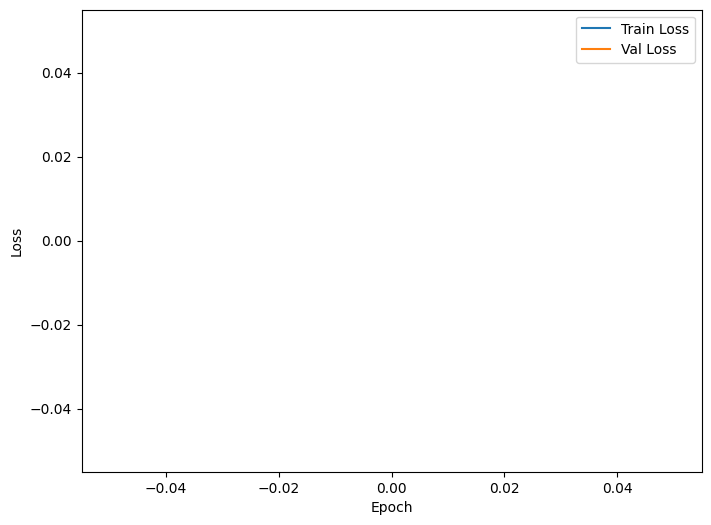

In [30]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    keep_best=True
)

As we can see from the previous training the model cannot be trained properly on the spectrograms corresponding to the music segments. To alleviate this problem, in the next sections we will introduce the max pooling operation to allow the network to extract relevant information from the input features and speed up the training procedure by reducing the size of the representations after each convolutional operation. Below we validate the model on the test set. As expected, the model has poor generalization on unseen data.

In [31]:
# Validating the best model
model = CNN(H=21, W=128).to(device)
model.load_state_dict(torch.load('model.pt'))
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn, device=device)

100%|██████████| 86/86 [00:01<00:00, 74.15it/s]


In [32]:
print(f'-Total Loss: {loss:3f}\n- F1 score: {f1:.3f}\n- Accuracy: {acc:.3f}')

-Total Loss: nan
- F1 score: 0.089
- Accuracy: 0.216


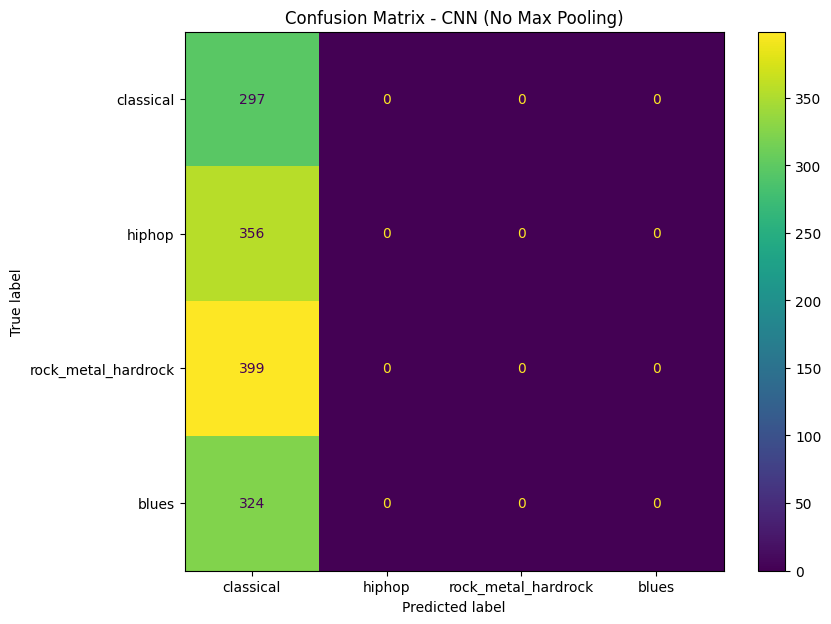

In [33]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (No Max Pooling)')
plt.show()

#### Step 4 (Pooling and Padding)

In this Step we add Max Pooling layers on the CNN architecture. There are many benefits of pooling operations:

1. Spatial down-sampling: Pooling operations, such as max pooling or average pooling, reduce the size of the feature maps. This downsampling reduces the computational complexity and memory requirements of subsequent layers in the network. By reducing the spatial dimensions, the model becomes more computationally efficient.

2. Translation invariance: Pooling helps to achieve some degree of translation invariance in the learned features. By summarizing the local information in a pooled representation, the network becomes less sensitive to small spatial variations in the input. This allows the network to recognize the same pattern or object regardless of its exact location in the input.

3. Feature extraction: Pooling operations help to capture the most salient features of the input. By performing operations like max pooling, which retains the maximum value within each pooling region, the network focuses on the most activated features, discarding less relevant information. This can improve the network's ability to detect important patterns and make the learned representations more robust.

4. Dimensionality reduction: Pooling reduces the number of parameters and computations required in the network, which can help prevent overfitting and improve generalization. By reducing the spatial dimensions, the number of parameters in subsequent layers is reduced, making the network less prone to overfitting and improving its ability to generalize well to new, unseen data.

To implement the Max Pooling in our code, we add a boolean flag `pooling` in the constructor of the CNN class. When this flag is set to True then after each convolution a Max pooling with kernel size equal to 2 and padding equal to 2 is used.

In [34]:
model = CNN(H=21, W=128, pooling=True).to(device)

In [35]:
EPOCHS = 30
learning_rate = 2e-3
loss_fn = nn.CrossEntropyLoss().to(device)
optim = SGD(model.parameters(), lr=learning_rate)

Epoch 1 /30. Train Loss: 1.283. Val Loss: 1.185


Epoch 2 /30. Train Loss: 1.056. Val Loss: 1.106


Epoch 3 /30. Train Loss: 0.917. Val Loss: 0.904


Epoch 4 /30. Train Loss: 0.823. Val Loss: 0.909


Epoch 5 /30. Train Loss: 0.754. Val Loss: 0.771


Epoch 6 /30. Train Loss: 0.713. Val Loss: 0.853


Epoch 7 /30. Train Loss: 0.659. Val Loss: 0.813


Epoch 8 /30. Train Loss: 0.631. Val Loss: 0.748


Epoch 9 /30. Train Loss: 0.604. Val Loss: 0.707


Epoch 10/30. Train Loss: 0.566. Val Loss: 0.697


Epoch 11/30. Train Loss: 0.536. Val Loss: 0.714


Epoch 12/30. Train Loss: 0.506. Val Loss: 0.707


Epoch 13/30. Train Loss: 0.467. Val Loss: 0.725


Epoch 14/30. Train Loss: 0.435. Val Loss: 0.708


Epoch 15/30. Train Loss: 0.413. Val Loss: 0.725


Epoch 16/30. Train Loss: 0.384. Val Loss: 0.711


Epoch 17/30. Train Loss: 0.344. Val Loss: 0.748


Epoch 18/30. Train Loss: 0.308. Val Loss: 0.717


Epoch 19/30. Train Loss: 0.266. Val Loss: 0.779


Epoch 20/30. Train Loss: 0.252. Val Loss: 0.742


Epoch 21/30. Train Loss: 0.217. Val Loss: 0.803


Epoch 22/30. Train Loss: 0.825. Val Loss: 0.925


Epoch 23/30. Train Loss: 0.366. Val Loss: 0.739


Epoch 24/30. Train Loss: 0.211. Val Loss: 1.003


Epoch 25/30. Train Loss: 0.147. Val Loss: 0.849


Epoch 26/30. Train Loss: 0.095. Val Loss: 0.907


Epoch 27/30. Train Loss: 0.065. Val Loss: 1.023


Epoch 28/30. Train Loss: 0.042. Val Loss: 0.993


Epoch 29/30. Train Loss: 0.031. Val Loss: 1.046


Epoch 30/30. Train Loss: 0.022. Val Loss: 1.114

- Total training time: 55.52 (secs)
- Best F1 score: 0.7585484761573074 on epoch 18


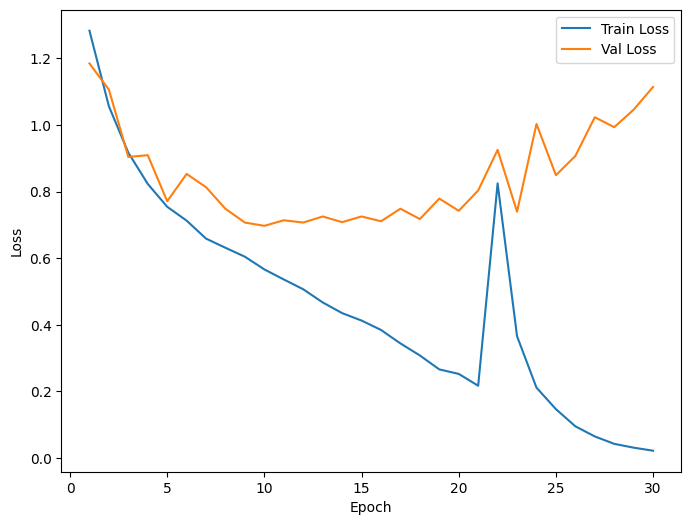

In [36]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    keep_best=True
)

As opposed to the non max pooling case, we see that this time the training and validation loss are finite numbers, meaning that this time the model is able to train on the spectrograms and extract relevant information from the features. However, we see that the training loss keeps decreasing while the validation loss stops decreasing after some point. This is a clear sign of overfitting. In the next sections we will introduce other deep learning techiniques, such as regularization and dropout to tackle this problem.

In [37]:
# Validating the best model
model = CNN(H=21, W=128, pooling=True).to(device)
model.load_state_dict(torch.load('model.pt'))
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn, device=device)

100%|██████████| 86/86 [00:00<00:00, 154.81it/s]


In [38]:
print(f'-Total Loss: {loss:3f}\n- F1 score: {f1:.3f}\n- Accuracy: {acc:.3f}')

-Total Loss: 0.787839
- F1 score: 0.749
- Accuracy: 0.743


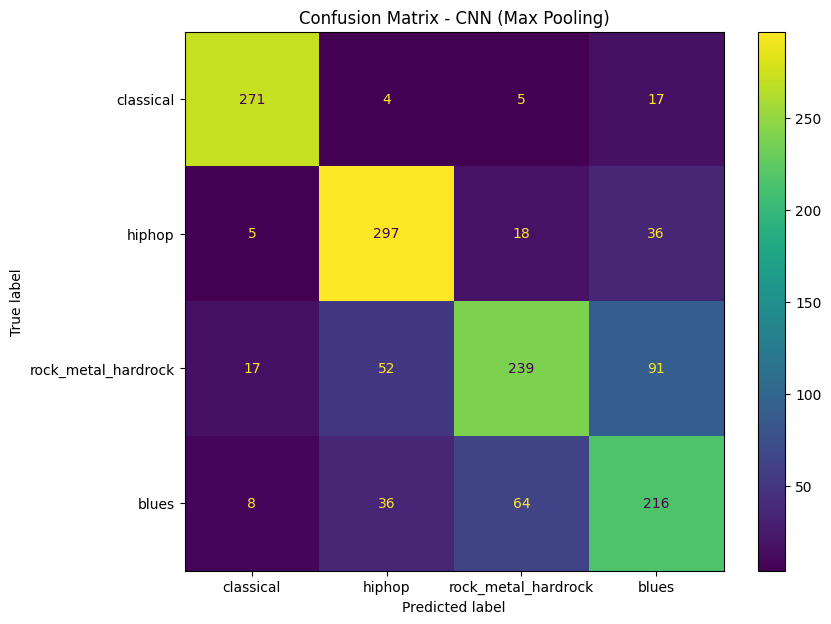

In [39]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (Max Pooling)')
plt.show()

#### Step 5 (Optimizers)

In this Step we try different optimizers and see the one that achieves the best generalization.

In [40]:
from torch.optim import Adam, SGD, Adagrad, RMSprop
import pandas as pd
from utils import train_and_validate

In [41]:
optims = [(Adam, 'Adam'), (SGD, 'SGD'), (Adagrad, 'Adagrad'), (RMSprop, 'RMSprop')]

In [42]:
EPOCHS = 30
learning_rate = 2e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss().to(device)

In [43]:
f1s, accs, losses, names = [], [], [], []
for optim, name in optims:
    model = CNN(H=21, W=128, pooling=True).to(device)
    op = optim(model.parameters(), lr=learning_rate)
    loss, f1, acc, _ = train_and_validate(
        model=model,
        epochs=EPOCHS,
        train_dloader=train_dloader,
        val_dloader=val_dloader,
        test_dloader=test_dloader,
        optim=op,
        loss_fn=loss_fn,
        device=device
    )
    names.append(name)
    f1s.append(f1)
    losses.append(loss)
    accs.append(acc)

In [44]:
results = pd.DataFrame({
    'F1 score': f1s,
    'Accuracy': accs,
    'Loss': losses
}, index=names).sort_values(by=['F1 score'], ascending=False)
results

,F1 score,Accuracy,Loss
Adagrad,0.775916,0.770349,0.701689
SGD,0.726930,0.720203,1.358612
Adam,0.722721,0.735465,0.860380
RMSprop,0.595550,0.589390,2.948394


We can see that the best performance is achieved when the CNN is trained with the Adagram optimizer. In the next sections we will use this optimizer.

## Step 3 (Improving Performance)

In this section we are experimenting with various deep learning methods in order to improve the performance of the CNN.

#### Step 1 (Reproducibility)

In order to decide which set up leads to the best generalization we will need to try different combinations, and hence, each experiment must be conducted under the same setting, in other words we will need to fix any kind of randomness that might be involved in our training procedure in such a way that each setup is tested under the same conditions. To this end, below we make all the necessary modifications such that the DataLoaders during training shuffle the dataset but in the same manner across different training runs. Furthermore, we set a random seed to the initialization weights of the CNN. To test that everything works as expected we try two identical training runs and check if the training/validation losses coincide.

In [45]:
# Setting a seed method to DataLoaders
g_cpu = torch.Generator(device='cpu')
train_dloader = DataLoader(
    SpectrogramDataset(*load_spectrograms("train")), batch_size=16, shuffle=True, generator=g_cpu
)
val_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("val")), batch_size=16, shuffle=True, generator=g_cpu)
# No need to seed the test loader
test_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("test")), batch_size=1, shuffle=False)

In [46]:
def set_epoch(self, epoch):
    self.epoch = epoch
    if self.shuffle:
        self.generator.manual_seed(2147483647 + self.epoch)

In [47]:
train_dloader.shuffle = True
train_dloader.set_epoch = set_epoch

val_dloader.shuffle = True
val_dloader.set_epoch = set_epoch

In [48]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [49]:
from models import CNN
from utils import train_and_validate

EPOCHS = 30
learning_rate = 2e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss().to(device)

In [50]:
for run in range(1, 3):
    torch.manual_seed(2147483647)
    model = CNN(pooling=True).to(device)
    optim = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    loss, f1, acc, _ = train_and_validate(
        model=model,
        epochs=EPOCHS,
        train_dloader=train_dloader,
        val_dloader=val_dloader,
        test_dloader=test_dloader,
        optim=optim,
        loss_fn=loss_fn,
        device=device,
        reproducibility=True
    )
    print(f'Run {run} --> Loss: {loss} | F1 score: {f1} | Accuracy: {acc}')


Run 1 --> Loss: 0.6514147093462471 | F1 score: 0.7680203113310511 | Accuracy: 0.7630813953488372
Run 2 --> Loss: 0.6514147093462471 | F1 score: 0.7680203113310511 | Accuracy: 0.7630813953488372


As we can see from the previous output, the results with respect to the total loss, the F1 score as well as for the accuracy coincide for the two identical training setups. Therefore, we can proceed by testing different training scenarios in order to find the optimal one.

##### Step 2 (Activation functions)

In this section we are experimenting with different activation functions. We set an argument `activation` in the class of the CNN that determines which activation function to be used. We apply the activation function after each convolutional operation as well as in the Feed Forward Network part of the CNN (i.e. the classifier).

In [51]:
activations = ['ReLU', 'ELU', 'Tanh', 'GeLU']
f1s, accs, losses, names = [], [], [], []
for f in activations:
    names.append(f)
    torch.manual_seed(2147483647)
    model = CNN(pooling=True, activation=f).to(device)
    optim = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    loss, f1, acc, _ = train_and_validate(
        model=model,
        epochs=EPOCHS,
        train_dloader=train_dloader,
        val_dloader=val_dloader,
        test_dloader=test_dloader,
        optim=optim,
        loss_fn=loss_fn,
        device=device,
        reproducibility=True
    )
    f1s.append(f1)
    accs.append(acc)
    losses.append(loss)
    print(f'Activation: {f} | Loss: {loss:.3f} | F1 score: {f1:.3f} Accuracy: {acc:.3f}')

Activation: ReLU | Loss: 1.478 | F1 score: 0.758 Accuracy: 0.753
Activation: ELU | Loss: 0.558 | F1 score: 0.798 Accuracy: 0.794
Activation: Tanh | Loss: 1.386 | F1 score: 0.103 Accuracy: 0.259
Activation: GeLU | Loss: 0.696 | F1 score: 0.757 Accuracy: 0.753


In [52]:
import pandas as pd

results = pd.DataFrame({
    'F1 score': f1s,
    'Accuracy': accs,
    'Loss': losses
}, index=names).sort_values(by=['F1 score'], ascending=False)
results

,F1 score,Accuracy,Loss
ELU,0.798448,0.794331,0.557765
ReLU,0.758058,0.752907,1.477783
GeLU,0.757445,0.752907,0.696341
Tanh,0.102771,0.258721,1.386191


##### Step 3 (Learning rate scheduler)

In this step we experiment with various learning rate schedules. We use the best model that we have so far which corresponds to the CNN with max pooling and ELU as activation function.

In [53]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

schedulers = [
    (StepLR, 'StepLR'),
    (ExponentialLR, 'ExponentialLR'),
    (CosineAnnealingLR, 'CosineAnnealingLR')
]
f1s, accs, losses, names = [], [], [], []

for scheduler, name in schedulers:
    print(f'- Scheduler: {name}\n\n')
    names.append(name)
    torch.manual_seed(2147483647)
    model = CNN(pooling=True, activation='ELU').to(device)
    optim = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    if name == 'CosineAnnealingLR':
        scheduler = scheduler(optimizer=optim, verbose=True, T_max=EPOCHS, eta_min=1e-4)
    elif name == 'StepLR':
        scheduler = scheduler(optimizer=optim, verbose=True, step_size=10, gamma=0.1)
    elif name == 'ExponentialLR':
        scheduler = scheduler(optimizer=optim, verbose=True, gamma=0.9)
    loss, f1, acc, _ = train_and_validate(
        model=model,
        epochs=EPOCHS,
        train_dloader=train_dloader,
        val_dloader=val_dloader,
        test_dloader=test_dloader,
        optim=optim,
        loss_fn=loss_fn,
        device=device,
        reproducibility=True,
        scheduler=scheduler,
        verbose=True
    )
    print(f'\n- Total loss: {loss:.3f} | F1: {f1:.3f} | Acc: {acc:.3f}\n\n')
    f1s.append(f1)
    accs.append(acc)
    losses.append(loss)

- Scheduler: StepLR


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 1 | Train loss 1.394 | Val loss 1.175
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 2 | Train loss 0.926 | Val loss 0.878
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 3 | Train loss 0.703 | Val loss 0.663
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 4 | Train loss 0.602 | Val loss 0.641
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 5 | Train loss 0.554 | Val loss 0.631
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 6 | Train loss 0.518 | Val loss 0.539
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 7 | Train loss 0.481 | Val loss 0.573
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 8 | Train loss 0.464 | Val loss 0.533
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 9 | Train loss 0.426 | Val loss 0.535
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 10 | Train loss 0.405 | Val loss 0.552
Adjusting learning rate of group 0 to

In [54]:
import pandas as pd

results = pd.DataFrame({
    'F1 score': f1s,
    'Accuracy': accs,
    'Loss': losses
}, index=names).sort_values(by=['F1 score'], ascending=False)
results

,F1 score,Accuracy,Loss
CosineAnnealingLR,0.797234,0.792151,0.569433
StepLR,0.795945,0.792151,0.559810
ExponentialLR,0.786286,0.781977,0.561007


##### Step 4 (Batch Normalization)

To further improve the performance of the CNN we apply a 2D Batch Normalization before each activation function.

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 1 | Train loss 0.810 | Val loss 0.702
Adjusting learning rate of group 0 to 1.9948e-03.
Epoch 2 | Train loss 0.585 | Val loss 0.581
Adjusting learning rate of group 0 to 1.9792e-03.
Epoch 3 | Train loss 0.513 | Val loss 0.524
Adjusting learning rate of group 0 to 1.9535e-03.
Epoch 4 | Train loss 0.464 | Val loss 0.557
Adjusting learning rate of group 0 to 1.9179e-03.
Epoch 5 | Train loss 0.427 | Val loss 0.558
Adjusting learning rate of group 0 to 1.8727e-03.
Epoch 6 | Train loss 0.389 | Val loss 0.583
Adjusting learning rate of group 0 to 1.8186e-03.
Epoch 7 | Train loss 0.341 | Val loss 0.600
Adjusting learning rate of group 0 to 1.7560e-03.
Epoch 8 | Train loss 0.319 | Val loss 0.616
Adjusting learning rate of group 0 to 1.6857e-03.
Epoch 9 | Train loss 0.268 | Val loss 0.669
Adjusting learning rate of group 0 to 1.6084e-03.
Epoch 10 | Train loss 0.239 | Val loss 0.636
Adjusting learning rate of group 0 to 1.5250e-03.
Epoch 11 

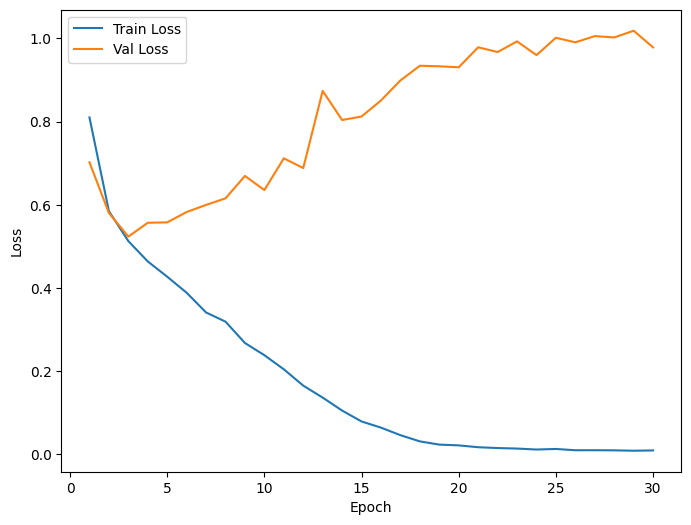

In [55]:
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(2147483647)

model = CNN(pooling=True, activation='ELU', batchnorm=True).to(device)
optim = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer=optim, verbose=True, T_max=EPOCHS, eta_min=1e-4)

loss, f1, acc, cm = train_and_validate(
    model=model,
    epochs=EPOCHS,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    test_dloader=test_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    reproducibility=True,
    scheduler=scheduler,
    verbose=True,
    plot=True
)

In [56]:
print(f'\n- Total loss: {loss:.3f} | F1: {f1:.3f} | Acc: {acc:.3f}')


- Total loss: 0.583 | F1: 0.781 | Acc: 0.776


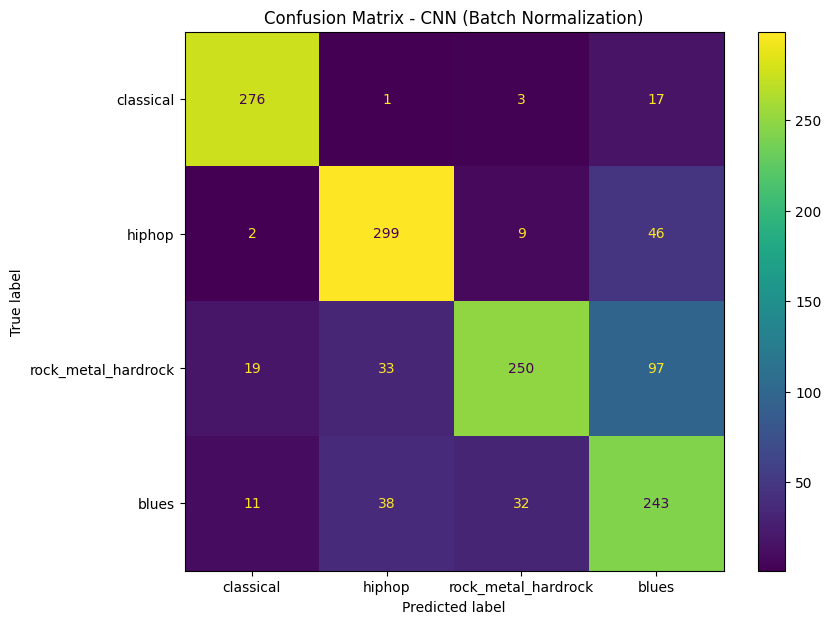

In [57]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (Batch Normalization)')
plt.show()

##### Step 5 (Regularization)

As we can see Batch Normalization improved the performance of the model about 3% in both the F1 and accuracy scores. However, from the train/val loss plot we can observe that the training loss constantly decreases while the validation loss stays the same after some point. To tackle this problem we can add a weight decay on the optimizer to act as a regularizer. Furthermore, we experiment by applying dropouts on the linear layers of the classifier.

###### Regulization (L2)

In [58]:
# Only Regularization
from torch.optim.lr_scheduler import CosineAnnealingLR

EPOCHS = 60
torch.manual_seed(2147483647)
model = CNN(pooling=True, activation='ELU', batchnorm=True).to(device)
optim = torch.optim.Adagrad(model.parameters(), lr=2e-3, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer=optim, verbose=True, T_max=EPOCHS, eta_min=1e-4)

Adjusting learning rate of group 0 to 2.0000e-03.


Epoch 1 | Train loss 0.825 | Val loss 0.788
Adjusting learning rate of group 0 to 1.9987e-03.
Epoch 2 | Train loss 0.607 | Val loss 0.607
Adjusting learning rate of group 0 to 1.9948e-03.
Epoch 3 | Train loss 0.540 | Val loss 0.529
Adjusting learning rate of group 0 to 1.9883e-03.
Epoch 4 | Train loss 0.499 | Val loss 0.563
Adjusting learning rate of group 0 to 1.9792e-03.
Epoch 5 | Train loss 0.465 | Val loss 0.581
Adjusting learning rate of group 0 to 1.9676e-03.
Epoch 6 | Train loss 0.433 | Val loss 0.555
Adjusting learning rate of group 0 to 1.9535e-03.
Epoch 7 | Train loss 0.390 | Val loss 0.598
Adjusting learning rate of group 0 to 1.9369e-03.
Epoch 8 | Train loss 0.363 | Val loss 0.585
Adjusting learning rate of group 0 to 1.9179e-03.
Epoch 9 | Train loss 0.316 | Val loss 0.635
Adjusting learning rate of group 0 to 1.8965e-03.
Epoch 10 | Train loss 0.283 | Val loss 0.526
Adjusting learning rate of group 0 to 1.8727e-03.
Epoch 11 | Train loss 0.245 | Val loss 0.645
Adjusting lear

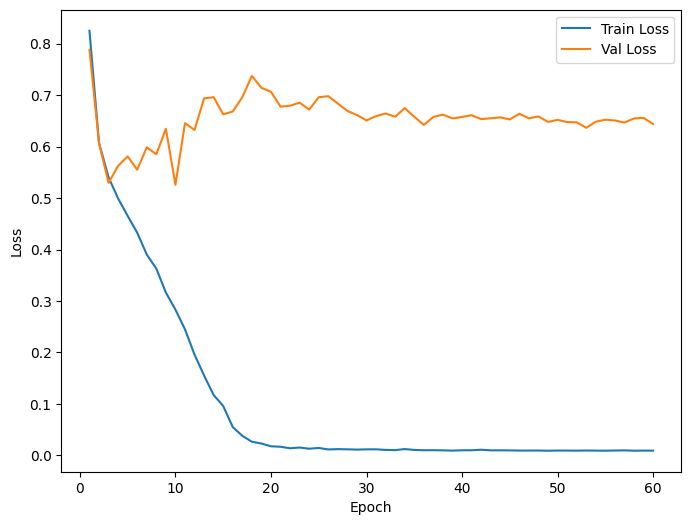

In [59]:
loss, f1, acc, cm = train_and_validate(
    model=model,
    epochs=EPOCHS,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    test_dloader=test_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    reproducibility=True,
    scheduler=scheduler,
    verbose=True,
    plot=True
)

In [60]:
print(f'\n- Total loss: {loss:.3f} | F1: {f1:.3f} | Acc: {acc:.3f}')


- Total loss: 0.585 | F1: 0.801 | Acc: 0.799


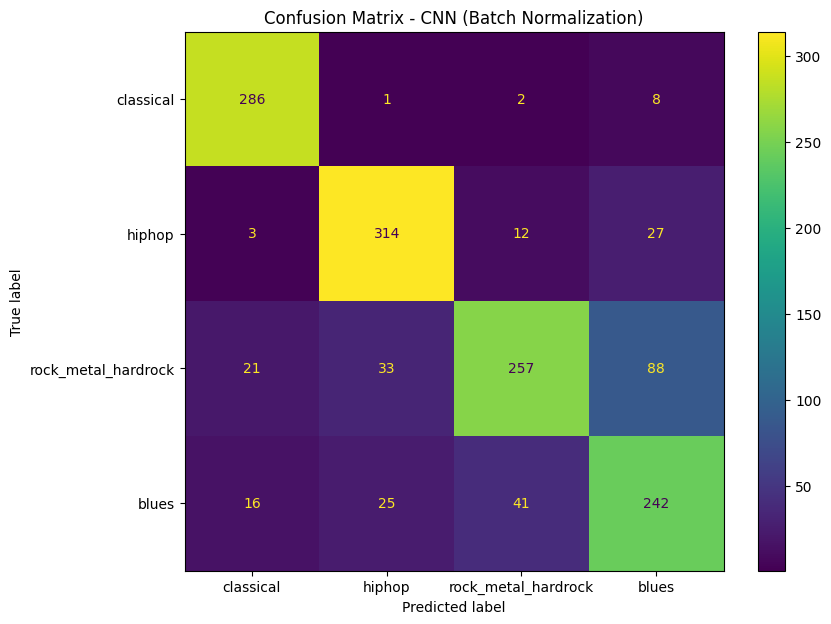

In [61]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (Batch Normalization)')
plt.show()

###### Dropout

In [62]:
# Dropout only

EPOCHS = 60
torch.manual_seed(2147483647)
model = CNN(pooling=True, activation='ELU', batchnorm=True, dropout_rate=0.2).to(device)
optim = torch.optim.Adagrad(model.parameters(), lr=2e-3)
scheduler = CosineAnnealingLR(optimizer=optim, verbose=True, T_max=EPOCHS, eta_min=1e-4)

Adjusting learning rate of group 0 to 2.0000e-03.


Epoch 1 | Train loss 0.884 | Val loss 0.687
Adjusting learning rate of group 0 to 1.9987e-03.
Epoch 2 | Train loss 0.632 | Val loss 0.595
Adjusting learning rate of group 0 to 1.9948e-03.
Epoch 3 | Train loss 0.551 | Val loss 0.515
Adjusting learning rate of group 0 to 1.9883e-03.
Epoch 4 | Train loss 0.507 | Val loss 0.533
Adjusting learning rate of group 0 to 1.9792e-03.
Epoch 5 | Train loss 0.473 | Val loss 0.581
Adjusting learning rate of group 0 to 1.9676e-03.
Epoch 6 | Train loss 0.432 | Val loss 0.578
Adjusting learning rate of group 0 to 1.9535e-03.
Epoch 7 | Train loss 0.389 | Val loss 0.570
Adjusting learning rate of group 0 to 1.9369e-03.
Epoch 8 | Train loss 0.366 | Val loss 0.587
Adjusting learning rate of group 0 to 1.9179e-03.
Epoch 9 | Train loss 0.332 | Val loss 0.681
Adjusting learning rate of group 0 to 1.8965e-03.
Epoch 10 | Train loss 0.308 | Val loss 0.575
Adjusting learning rate of group 0 to 1.8727e-03.
Epoch 11 | Train loss 0.275 | Val loss 0.705
Adjusting lear

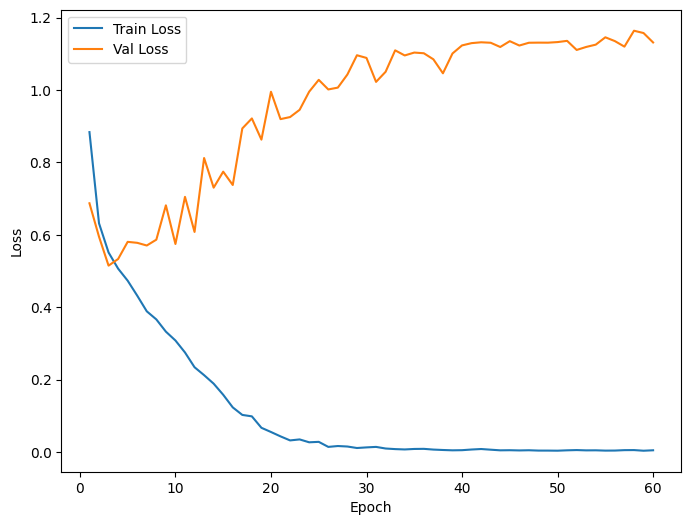

In [63]:
loss, f1, acc, cm = train_and_validate(
    model=model,
    epochs=EPOCHS,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    test_dloader=test_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    reproducibility=True,
    scheduler=scheduler,
    verbose=True,
    plot=True
)

In [64]:
print(f'\n- Total loss: {loss:.3f} | F1: {f1:.3f} | Acc: {acc:.3f}')


- Total loss: 0.582 | F1: 0.781 | Acc: 0.773


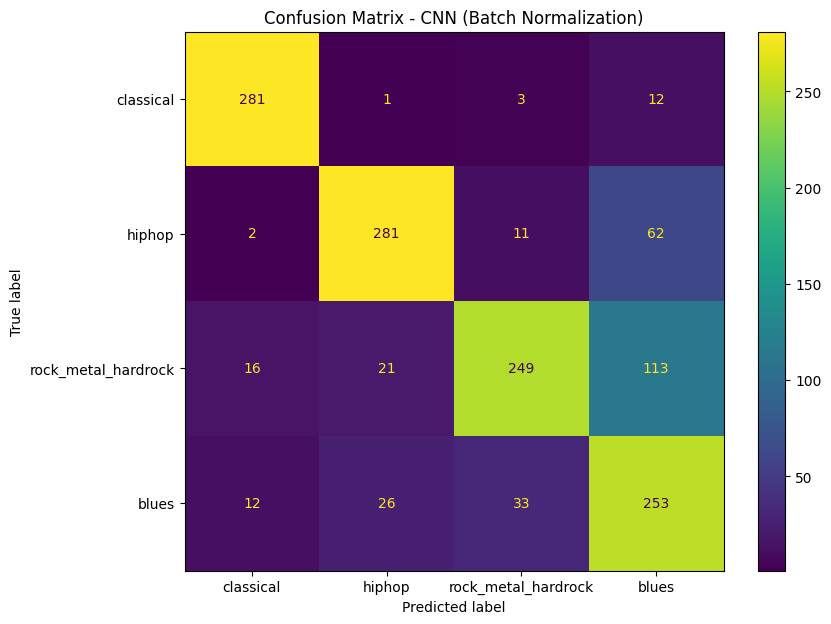

In [65]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (Batch Normalization)')
plt.show()

###### Regularization + Dropout

In [66]:
# Regularization + Dropout

EPOCHS = 60
torch.manual_seed(2147483647)
model = CNN(pooling=True, activation='ELU', batchnorm=True, dropout_rate=0.2).to(device)
optim = torch.optim.Adagrad(model.parameters(), lr=2e-3, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer=optim, verbose=True, T_max=EPOCHS, eta_min=1e-4)

Adjusting learning rate of group 0 to 2.0000e-03.


Epoch 1 | Train loss 0.883 | Val loss 0.720
Adjusting learning rate of group 0 to 1.9987e-03.
Epoch 2 | Train loss 0.636 | Val loss 0.673
Adjusting learning rate of group 0 to 1.9948e-03.
Epoch 3 | Train loss 0.567 | Val loss 0.516
Adjusting learning rate of group 0 to 1.9883e-03.
Epoch 4 | Train loss 0.522 | Val loss 0.550
Adjusting learning rate of group 0 to 1.9792e-03.
Epoch 5 | Train loss 0.498 | Val loss 0.609
Adjusting learning rate of group 0 to 1.9676e-03.
Epoch 6 | Train loss 0.459 | Val loss 0.544
Adjusting learning rate of group 0 to 1.9535e-03.
Epoch 7 | Train loss 0.421 | Val loss 0.552
Adjusting learning rate of group 0 to 1.9369e-03.
Epoch 8 | Train loss 0.399 | Val loss 0.573
Adjusting learning rate of group 0 to 1.9179e-03.
Epoch 9 | Train loss 0.357 | Val loss 0.635
Adjusting learning rate of group 0 to 1.8965e-03.
Epoch 10 | Train loss 0.333 | Val loss 0.534
Adjusting learning rate of group 0 to 1.8727e-03.
Epoch 11 | Train loss 0.299 | Val loss 0.666
Adjusting lear

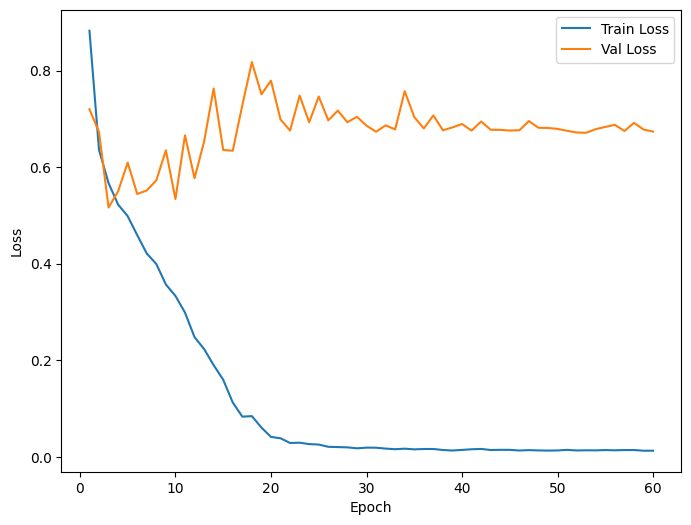

In [67]:
loss, f1, acc, cm = train_and_validate(
    model=model,
    epochs=EPOCHS,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    test_dloader=test_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    reproducibility=True,
    scheduler=scheduler,
    verbose=True,
    plot=True
)

In [68]:
print(f'\n- Total loss: {loss:.3f} | F1: {f1:.3f} | Acc: {acc:.3f}')


- Total loss: 0.577 | F1: 0.787 | Acc: 0.781


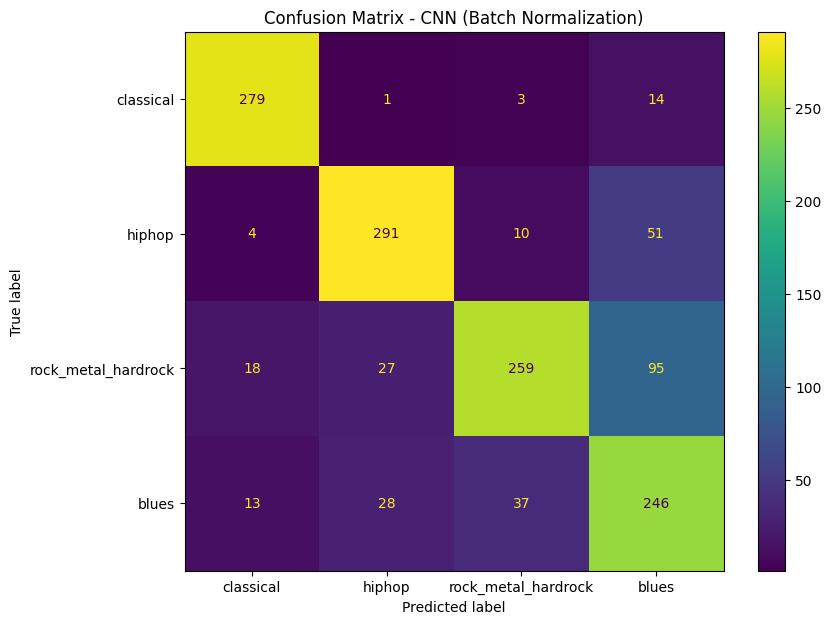

In [69]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (Batch Normalization)')
plt.show()

##### Step 6 (Training efficiency)

In this step we try different batch sizes and we use Early stopping in order to reduce the training time.

In [70]:
from models import CNN
from utils import train_and_validate, SpectrogramDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

batch_sizes = [2**4, 2**5, 2**6, 2**7]
EPOCHS = 60
learning_rate = 2e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss().to(device)

batches, losses, f1s, accs, times = [], [], [], [], []

for batch_size in batch_sizes:
    train_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("train")), batch_size=batch_size, shuffle=True)
    val_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("val")), batch_size=batch_size, shuffle=True)
    test_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("test")), batch_size=1, shuffle=False)

    model = CNN(pooling=True, activation='ELU', batchnorm=True).to(device)
    optim = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-2)
    scheduler = CosineAnnealingLR(optimizer=optim, verbose=True, T_max=EPOCHS, eta_min=1e-4)

    tic = time.perf_counter()
    loss, f1, acc, _ = train_and_validate(
        model=model,
        epochs=EPOCHS,
        train_dloader=train_dloader,
        val_dloader=val_dloader,
        test_dloader=test_dloader,
        optim=optim,
        loss_fn=loss_fn,
        device=device,
        scheduler=scheduler,
        verbose=False,
        f1_flag=False,
        ear_stopping_flag=True
    )
    tac = time.perf_counter()
    batches.append(batch_size)
    losses.append(loss)
    f1s.append(f1)
    accs.append(acc)
    times.append(tac - tic)

    print(f'Batch size: {batch_size} | F1 score: {f1:.3f} | Acc: {acc:.3f} | Time: {(tac-tic):.3f}')

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 1.9987e-03.
Adjusting learning rate of group 0 to 1.9948e-03.
Adjusting learning rate of group 0 to 1.9883e-03.
EarlyStopping counter: 1 out of 7
Adjusting learning rate of group 0 to 1.9792e-03.
EarlyStopping counter: 2 out of 7
Adjusting learning rate of group 0 to 1.9676e-03.
Adjusting learning rate of group 0 to 1.9535e-03.
EarlyStopping counter: 1 out of 7
Adjusting learning rate of group 0 to 1.9369e-03.
EarlyStopping counter: 2 out of 7
Adjusting learning rate of group 0 to 1.9179e-03.
EarlyStopping counter: 3 out of 7
Adjusting learning rate of group 0 to 1.8965e-03.
EarlyStopping counter: 4 out of 7
Adjusting learning rate of group 0 to 1.8727e-03.
EarlyStopping counter: 5 out of 7
Adjusting learning rate of group 0 to 1.8467e-03.
EarlyStopping counter: 6 out of 7
Adjusting learning rate of group 0 to 1.8186e-03.
EarlyStopping counter: 7 out of 7
Early stopping
Batch size: 16 | F1 score: 0.

In [71]:
import pandas as pd

results = pd.DataFrame({
    'F1 score': f1s,
    'Accuracy': accs,
    'Losses': losses,
    'Time': times
}, index=batch_sizes).sort_values(by=['F1 score'], ascending=False)

results

,F1 score,Accuracy,Losses,Time
128,0.801292,0.797238,0.546161,59.169055
64,0.794554,0.791424,0.571500,74.716742
16,0.773724,0.773983,0.579704,41.728220
32,0.760083,0.763808,0.592190,33.928724


We see that the highest F1 score is achieved for batch size equal to 64. Below we perform the last training with the best hyperparameters to get the best model weights that we will use for inference in the last section.

In [72]:
model = CNN(pooling=True, activation='ELU', batchnorm=True).to(device)
optim = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer=optim, verbose=True, T_max=EPOCHS, eta_min=1e-4)

Adjusting learning rate of group 0 to 2.0000e-03.


In [73]:
train_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("train")), batch_size=64, shuffle=True)
val_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("val")), batch_size=64, shuffle=True)
test_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("test")), batch_size=1, shuffle=False)

Epoch 1 | Train loss 1.018 | Val loss 0.855
Validation loss decreased (inf --> 0.854794).  Saving model ...
Adjusting learning rate of group 0 to 1.9987e-03.
Epoch 2 | Train loss 0.655 | Val loss 0.571
Validation loss decreased (0.854794 --> 0.571317).  Saving model ...
Adjusting learning rate of group 0 to 1.9948e-03.
Epoch 3 | Train loss 0.564 | Val loss 1.258
EarlyStopping counter: 1 out of 7
Adjusting learning rate of group 0 to 1.9883e-03.
Epoch 4 | Train loss 0.531 | Val loss 0.707
EarlyStopping counter: 2 out of 7
Adjusting learning rate of group 0 to 1.9792e-03.
Epoch 5 | Train loss 0.491 | Val loss 0.822
EarlyStopping counter: 3 out of 7
Adjusting learning rate of group 0 to 1.9676e-03.
Epoch 6 | Train loss 0.454 | Val loss 0.579
EarlyStopping counter: 4 out of 7
Adjusting learning rate of group 0 to 1.9535e-03.
Epoch 7 | Train loss 0.438 | Val loss 0.542
Validation loss decreased (0.571317 --> 0.542030).  Saving model ...
Adjusting learning rate of group 0 to 1.9369e-03.
Epoc

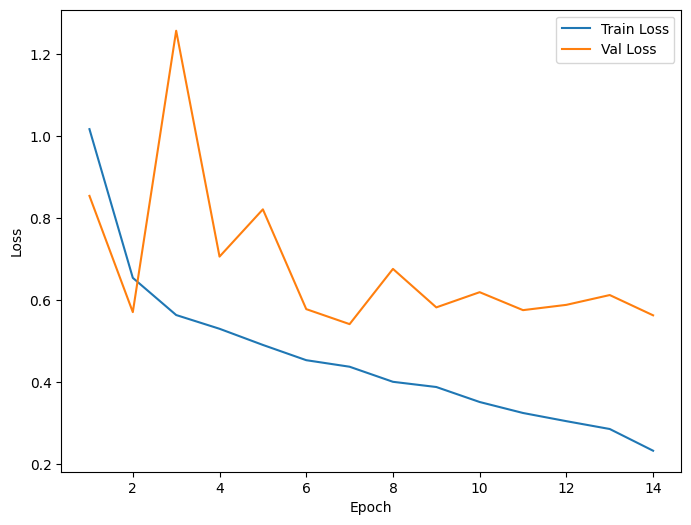

In [74]:
loss, f1, acc, cm = train_and_validate(
    model=model,
    epochs=EPOCHS,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    test_dloader=test_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    scheduler=scheduler,
    verbose=True,
    f1_flag=False,
    ear_stopping_flag=True,
    plot=True
)

In [75]:
print(f'F1 score: {f1:.3f} | Acc: {acc:.3f} | Time: {(tac-tic):.3f}')

F1 score: 0.804 | Acc: 0.800 | Time: 59.169


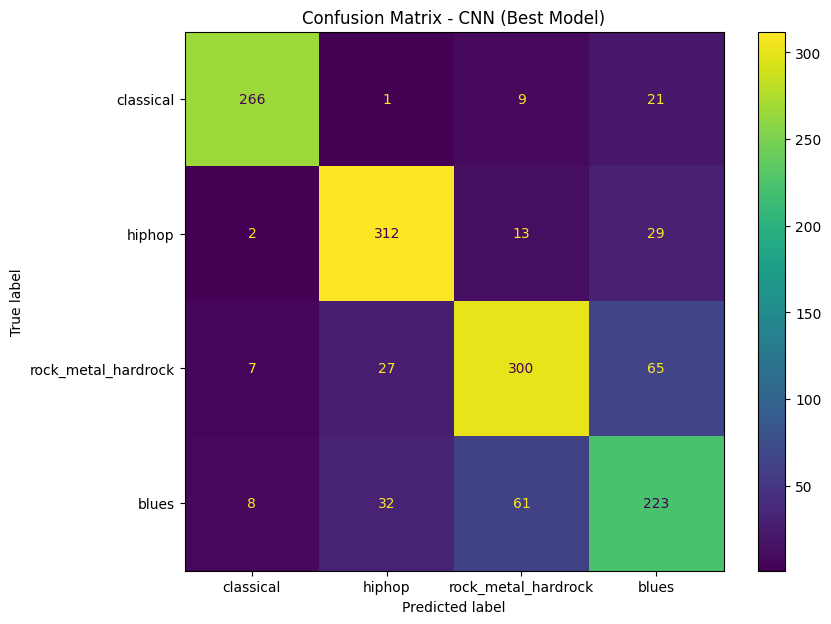

In [76]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (Best Model)')
plt.show()

### Step 4 (Testing)

In this section we use the best model obtained from the previous experiments in order to make predictions to songs downloaded from youtube. We use the script `youtube.py` to download the songs from youtube and extract the spectrograms representations for each 1 second of the downloaded songs.

##### Step 1 (Inference)

We first construct a utility function that will be used for inference.

In [77]:
from utils import INV_CLASS_MAPPING, CLASS_MAPPING
from sklearn.metrics import accuracy_score
from models import CNN
from utils import SpectrogramDataset
from torch.utils.data import DataLoader

def inference(model, d_loader, song_name):
    model.eval()
    y_pred = []
    y_pred_2 = []
    y_true_2 = []
    with torch.no_grad():
        for X, y in d_loader:
            out = model(X)
            pred = torch.argmax(out, dim=-1)
            y_pred_2.append(pred.item())
            y_true_2.append(y.item())
            y_pred.append(INV_CLASS_MAPPING[pred.item()])
            true_genre = INV_CLASS_MAPPING[y.item()]
    
    results = {}
    y_pred_2 = np.array(y_pred_2)
    for k, v in CLASS_MAPPING.items():
        results[k] = len(y_pred_2[y_pred_2 == v])
    results['total predictions'] = len(y_pred_2)
    results['Accuracy'] = accuracy_score(y_true_2, y_pred_2)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(range(len(y_pred)), y_pred, s=5)
    ax.set_xlabel('Timestamp [s]')
    ax.set_ylabel('Genre')
    ax.set_title(f'Predictions for {song_name} ({true_genre})')
    plt.legend()
    plt.show()
    
    print(f'\n{results}')

##### Step 2 & 3 (Downloading songs and Inference)

In [78]:
from youtube import youtube_to_melgram

songs = {
    'Chopin - Nocturne': {
        'url': 'https://www.youtube.com/watch?v=9E6b3swbnWg',
        'genre': 'classical',
        'name': 'Nocturne'
    },
    'Madonna - Hung Up': {
        'url': 'https://www.youtube.com/watch?v=EDwb9jOVRtU',
        'genre': 'hiphop',
        'name': 'Hung_up'
    },
    'Placebo - Every You Every Me': {
        'url': 'https://www.youtube.com/watch?v=OMaycNcPsHI',
        'genre': 'rock_metal_hardrock',
        'name': 'Placebo'
    },
    'BB King:How Blue Can You Get': {
        'url': 'https://www.youtube.com/watch?v=l45f28PzfCI',
        'genre': 'blues',
        'name': 'BB_King'
    }
}

In [79]:
model = CNN(pooling=True, activation='ELU', batchnorm=True)
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


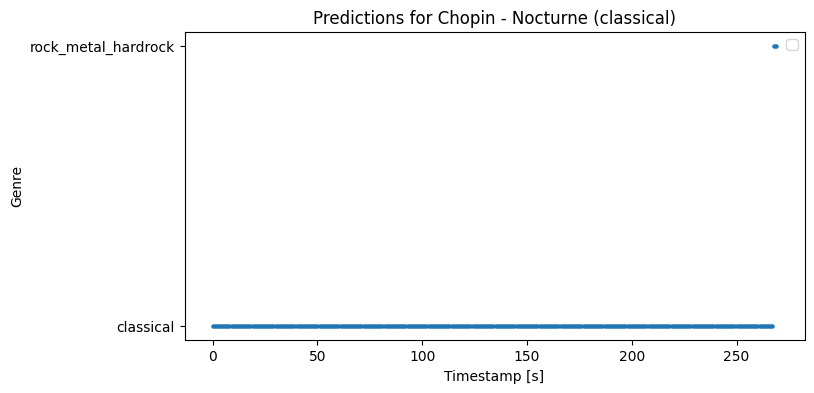


{'classical': 268, 'hiphop': 0, 'rock_metal_hardrock': 2, 'blues': 0, 'total predictions': 270, 'Accuracy': 0.9925925925925926}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


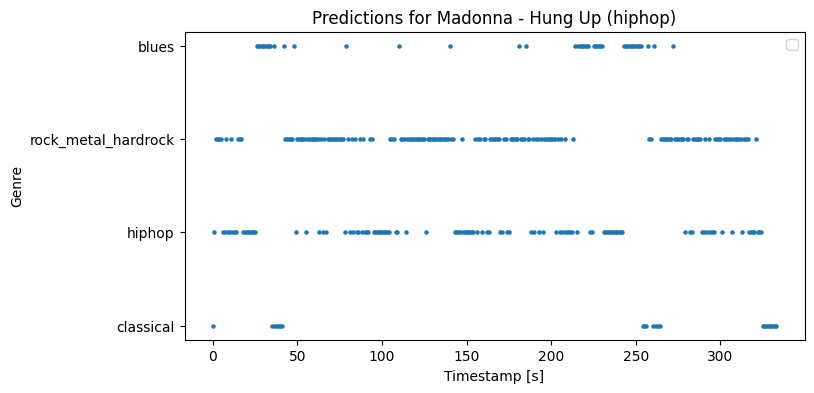


{'classical': 23, 'hiphop': 108, 'rock_metal_hardrock': 158, 'blues': 45, 'total predictions': 334, 'Accuracy': 0.32335329341317365}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


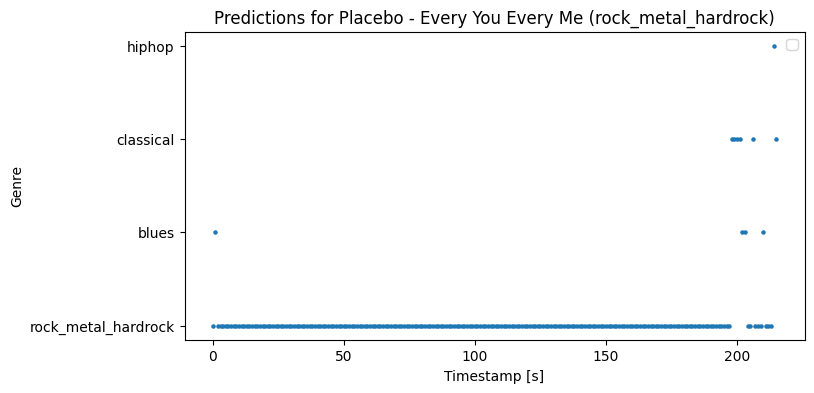


{'classical': 6, 'hiphop': 1, 'rock_metal_hardrock': 205, 'blues': 4, 'total predictions': 216, 'Accuracy': 0.9490740740740741}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


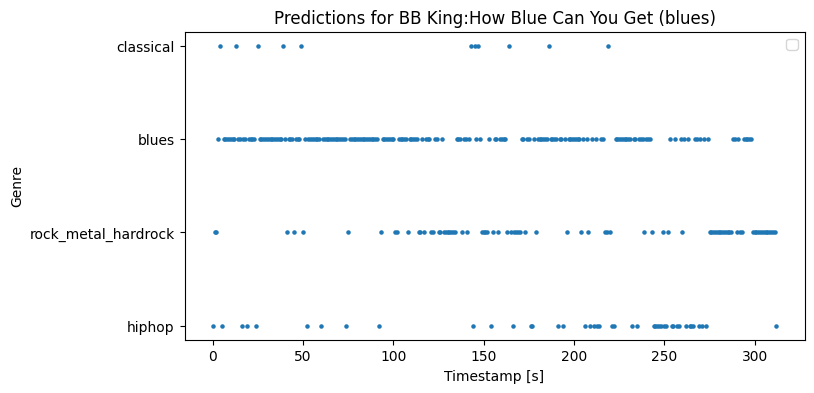


{'classical': 11, 'hiphop': 44, 'rock_metal_hardrock': 80, 'blues': 178, 'total predictions': 313, 'Accuracy': 0.5686900958466453}


In [80]:
# Inference on songs

for song_name in songs:
    X = youtube_to_melgram(songs[song_name]['url'], songs[song_name]['name'])
    y = X.shape[0] * [CLASS_MAPPING[songs[song_name]['genre']]]
    
    d_loader = DataLoader(SpectrogramDataset(X, y), batch_size=1, shuffle=False)
    inference(model, d_loader, song_name)